In [20]:
from scipy.integrate import quad
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
# K1 function
def integrand(t, xi):
    return np.exp(-xi * t)*(1/t**2 + 1/(2*t**4))*np.sqrt(t**2 - 1)

def K1_scalar(xi, T=300.0, n_sub=1000):
    # choose breakpoints on [1, T]; last piece [T, inf]
    breaks = np.linspace(1, T, n_sub+1)   # n_sub subintervals between 1 and T
    total = 0.0
    for a, b in zip(breaks[:-1], breaks[1:]):
        total += quad(lambda t: integrand(t, xi), a, b)[0]
    total += quad(lambda t: integrand(t, xi), T, np.inf)[0]
    return total

# vector input
def K1(x):
    if np.isscalar(x):
        return K1_scalar(x)
    return np.array([K1_scalar(xi) for xi in x])

x=np.concatenate((np.array([0.0]), np.logspace(-5,2,1000)))
K1=K1(x)
K1_spline = CubicSpline(x, K1, bc_type='natural')

y=np.linspace(0,1,1000)
plt.plot(y, K1_spline(y))
plt.yscale('log')
plt.title('K1')
plt.show()

/tmp/ipykernel_4922/1192541291.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total += quad(lambda t: integrand(t, xi), T, np.inf)[0]


KeyboardInterrupt: 

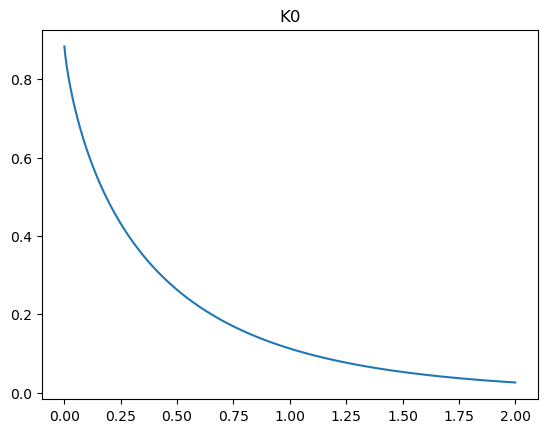

In [ ]:
# K0= integral of -K1
def K0(x):
    if np.isscalar(x):
        return quad(lambda t: -K1_spline(t), 0.2, x)[0]
    else:
        return np.array([quad(lambda t: -K1_spline(t), 100, xi)[0] for xi in x])

x=np.concatenate((np.array([0.0]), np.logspace(-5,2,1000)))
K0_array=K0(x)
K0_spline = CubicSpline(x, K0_array, bc_type='natural')
y=np.linspace(0.0,2,1000)
plt.plot(y, K0_spline(y))
#plt.yscale('log')
plt.title('K0')

data = np.vstack((x, K0_array)).T    # columns: x, K0(x)
np.savetxt('./tmp/function_splines/K0_func.txt', data, fmt='%.18e', delimiter=' ')

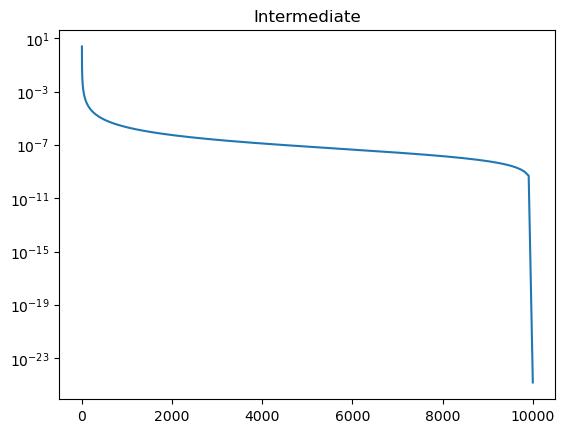

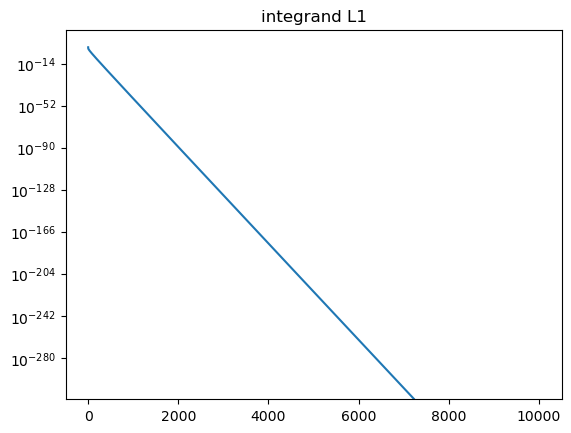

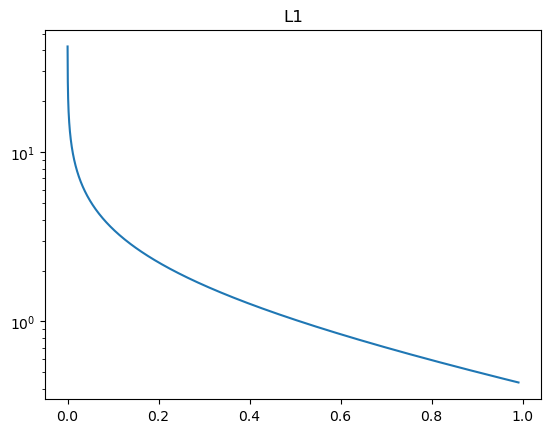

In [58]:
#L1 function

#intermediate function for L0
def intermediate(y):
    return (3*y**2-1)/(y*(y**2-1))*np.log(y+np.sqrt(y**2-1))-1/np.sqrt(y**2-1)*np.log(8*y*(y**2-1))

subintervals=np.logspace(0,4,300)
cutoff_y=subintervals[-1]
def int_intermediate(t):
    # filter points to lie strictly within (t, cutoff_y)
    valid_points = subintervals[(subintervals > t) & (subintervals < cutoff_y)]
    return quad(lambda y: intermediate(y), t, cutoff_y, points=valid_points,limit=2*subintervals.size)[0]

int_intermediate = np.vectorize(int_intermediate)

y = subintervals
intermediate_vals = int_intermediate(y)
intermediate_spline = CubicSpline(y, intermediate_vals, bc_type='natural')
y=np.logspace(0,4,1000)
plt.plot(y, intermediate_spline(y))
plt.yscale('log')
plt.title('Intermediate')
plt.show()

def integrand_L1(x,t):
    return np.exp(-x*t)*( (-13./54*t**(-2)-7./108*t**(-4)-2./9*t**(-6))*np.sqrt(t**2-1) \
            +( (44./9)*t**(-1)-2./3*t**(-3)-5./4*t**(-5)-2./9*t**(-7))* np.log(t+np.sqrt(t**2-1)) \
            + (-4./3*t**(-2)-2./3*t**(-4))*np.sqrt(t**2-1)*np.log(8*t*(t**2-1)) \
            + (8./3*t**(-1)-2./3*t**(-5))*intermediate_spline(t) )

subintervals_t=np.logspace(0.0001,4,200)
cuttoff_t=subintervals_t[-1]

def L1(x):
    if np.isscalar(x):
        return quad(lambda t: integrand_L1(x, t), 1, cuttoff_t, points=subintervals_t, limit=2*subintervals_t.size)[0] 


x=0.1
plt.plot(subintervals_t, integrand_L1(x, subintervals_t))
plt.yscale('log')
plt.title('integrand L1')
plt.show()

x=np.concatenate((np.array([0.0]), np.logspace(-5,2,1000)))
L1=np.vectorize(L1)
L1_values=L1(x)
L1_spline = CubicSpline(x, L1_values, bc_type='natural')

plt.plot(x[x<1], L1_spline(x[x<1]))
plt.yscale('log')
plt.title('L1')
plt.show()

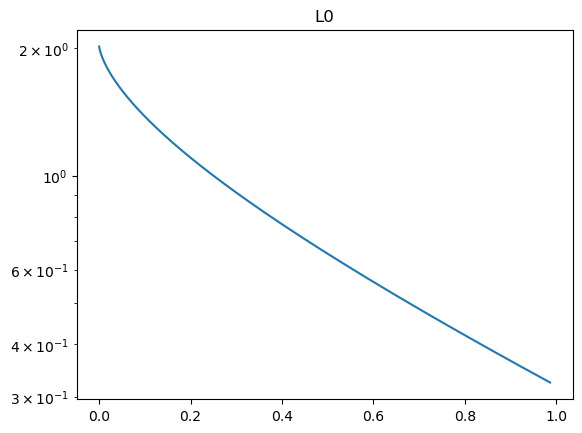

In [92]:
#L0 function 
subintervals_x=np.concatenate((np.array([0.0]), np.logspace(-5,2,300)))
def L0(x):
    if np.isscalar(x):
        return quad(lambda t: -L1_spline(t), 80., x)[0]
L0=np.vectorize(L0)

x=np.concatenate((np.array([0.0]), np.logspace(-5,2,500)))
L0_values=L0(x)
L0_spline = CubicSpline(x, L0_values, bc_type='natural')

plt.plot(x[x<1], L0_spline(x[x<1]))
plt.yscale('log')
plt.title('L0')
plt.show()

data = np.vstack((x, L0_values)).T    # columns: x, L0(x)
np.savetxt('./tmp/function_splines/L0_func.txt', data, fmt='%.18e', delimiter=' ')

Text(0.5, 1.0, 'Sample charge density')

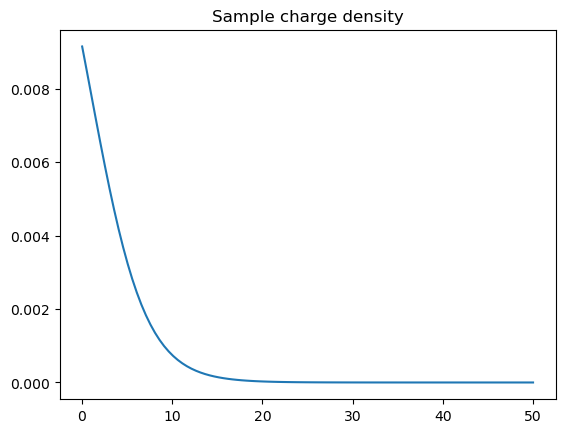

In [ ]:
# Example charge distribution
import phasr as phr
nucleus=phr.nucleus('Fermi', 13, 27,c=1.,z=3.,w=0.0)
r=np.linspace(0.01,50,100)
plt.plot(r, nucleus.charge_density(r))
plt.title('Sample charge density')

In [94]:
# Load data from file
data = np.loadtxt('./tmp/function_splines/K0_func.txt')
x_data = data[:, 0]    # first column
y_data = data[:, 1]    # second column

# Create spline
K0_spline = CubicSpline(x_data, y_data, bc_type='natural')

# Similarly for L0
data_L0 = np.loadtxt('./tmp/function_splines/L0_func.txt')
x_L0 = data_L0[:, 0]
y_L0 = data_L0[:, 1]
L0_spline = CubicSpline(x_L0, y_L0, bc_type='natural')

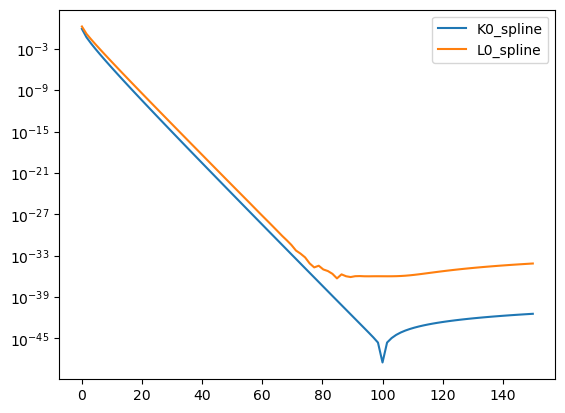

In [ ]:
# Test loaded splines
r=np.linspace(0.01,150,100)
plt.plot(r, np.abs(K0_spline(r)),label='K0_spline')
plt.plot(r, np.abs(L0_spline(r)),label='L0_spline')
plt.legend()
plt.yscale('log')

Text(0, 0.5, 'Potential (MeV)')

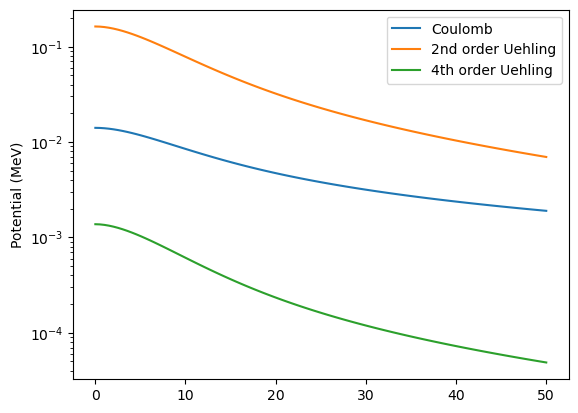

In [111]:
le=386.159 # in fm
e2=1.44 # in MeV*fm
alpha=1/137.035999084
Z=nucleus.Z
def potential_V2_integral(r_prime,r):
    return r_prime*nucleus.charge_density(r_prime)*(K0_spline(2/le*np.abs(r-r_prime))-K0_spline(2/le*(r+r_prime)))

def potential_V4_integral(r_prime,r):
    return r_prime*nucleus.charge_density(r_prime)*(L0_spline(2/le*np.abs(r-r_prime))-L0_spline(2/le*(r+r_prime)))

cutoff=10*le
subintervals=np.logspace(-1,np.log10(cutoff),500)
def V2_potential(r):
    return -2./3.*Z*alpha*le*e2/r*quad(lambda r_prime: potential_V2_integral(r_prime,r), 0, cutoff, points=subintervals, limit=2*subintervals.size)[0]
V2_potential = np.vectorize(V2_potential)

def V4_potential(r):
    return -Z*alpha**2*le*e2/(np.pi*r)*quad(lambda r_prime: potential_V4_integral(r_prime,r), 0, cutoff, points=subintervals, limit=2*subintervals.size)[0]
V4_potential = np.vectorize(V4_potential)

r=np.linspace(0.01,50.,100)
V0_vals=nucleus.electric_potential_ana(r)
#V2_vals=V2_potential(r)
#V4_vals=V4_potential(r)
plt.plot(r, np.abs(V0_vals), label='Coulomb')
plt.plot(r, np.abs(V2_vals), label='2nd order Uehling')
plt.plot(r, np.abs(V4_vals), label='4th order Uehling')
plt.legend()
plt.yscale('log')
plt.ylabel('Potential (MeV)')
